# Modules

In [27]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np

from pdathome.constants import paths, arm_labels_rename
from paradigma.windowing import create_segments, categorize_segments

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
subject = 'hbv012'

# load gait predictions for free living label
df_gait_predictions = pd.read_pickle(os.path.join(paths.PATH_GAIT_PREDICTIONS, 'rf', f'{subject}.pkl'))

df_gait_predictions = df_gait_predictions.loc[df_gait_predictions['free_living_label']=='Walking', ['time', 'pre_or_post', 'side']]

df_gait_predictions = df_gait_predictions.loc[df_gait_predictions['side']=='MAS']
df_gait_predictions['segment_nr'] = create_segments(
    df=df_gait_predictions, 
    time_column_name='time',
    segment_column_name='segment_nr',
    gap_threshold_s=1.5
)

# arm activity features
df_features = pd.read_pickle(os.path.join(paths.PATH_ARM_ACTIVITY_FEATURES, f'{subject}_MAS.pkl'))
df_ts = pd.read_pickle(os.path.join(paths.PATH_ARM_ACTIVITY_FEATURES, f'{subject}_MAS_ts.pkl'))

df_features['peak_velocity'] = (df_features['forward_peak_ang_vel_mean'] + df_features['backward_peak_ang_vel_mean'])/2
df_features = df_features.drop(columns=['time'])

df_ts_exploded = df_ts.explode(['time', 'arm_label'])

df_features = pd.merge(left=df_features, right=df_ts_exploded, how='right', on=['pre_or_post', 'segment_nr', 'window_nr'])
df_features = df_features.groupby(['time', 'pre_or_post'])[['peak_velocity', 'range_of_motion']].mean().reset_index()

# arm activity predictions
df_predictions = pd.read_pickle(os.path.join(paths.PATH_ARM_ACTIVITY_PREDICTIONS, 'logreg', f'{subject}.pkl'))
df_predictions = df_predictions.loc[df_predictions['side']=='MAS']

# set pred rounded
df_predictions['pred_other_arm_activity'] = (df_predictions['pred_other_arm_activity_proba'] >= 0.5).astype(int)

df_predictions.loc[df_predictions['arm_label']=='Gait without other behaviours or other positions', 'other_arm_activity_boolean'] = 0
df_predictions.loc[df_predictions['arm_label']!='Gait without other behaviours or other positions', 'other_arm_activity_boolean'] = 1
df_predictions.loc[df_predictions['arm_label']=='Holding an object behind ', 'arm_label'] = 'Holding an object behind'
df_predictions['arm_label'] = df_predictions.loc[~df_predictions['arm_label'].isna(), 'arm_label'].apply(lambda x: arm_labels_rename[x])

df = pd.merge(left=df_predictions, right=df_gait_predictions, how='left', on=['time', 'pre_or_post', 'side'])
df = pd.merge(left=df, right=df_features, how='left', on=['time', 'pre_or_post'])

In [41]:
df_all_mas = df.copy()

df_all_mas['dataset'] = 'Predicted gait'

df_all_mas['segment_category'] = categorize_segments(
    df=df_all_mas,
    segment_nr_colname='segment_nr',
    sampling_frequency=100
)
# df, segment_nr_colname, sampling_frequency

df_pred_mas = df_all_mas.loc[(df_all_mas['pred_other_arm_activity']==0)].copy()
df_pred_mas['dataset'] = 'Predicted gait predicted NOAA'

df_ann_mas = df_all_mas.loc[(df_all_mas['other_arm_activity_boolean']==0)].copy()
df_ann_mas['dataset'] = 'Predicted gait annotated NOAA'

df_mas = pd.concat([df_all_mas, df_pred_mas], axis=0).reset_index(drop=True)
df_mas = pd.concat([df_mas, df_ann_mas], axis=0).reset_index(drop=True)

In [42]:
# effect size: verschil (point estimate) gedeeld door de std van het verschil (sd van point estimate van bootstrapping)
measure = 'range_of_motion'
stat = 'median'

d_effect_size = {}
d_diffs = {}

for dataset in df_mas['dataset'].unique():
    d_effect_size[dataset] = {}

    for segment_category in ['short', 'moderately_long', 'long', 'very_long', 'overall']:
        df_pre = df_mas.loc[(df_mas['dataset']==dataset) & (df_mas['pre_or_post']=='pre')]
        df_post = df_mas.loc[(df_mas['dataset']==dataset) & (df_mas['pre_or_post']=='post')]

        if segment_category != 'overall':
            df_pre = df_pre.loc[df_pre['segment_category']==segment_category]
            df_post = df_post.loc[df_post['segment_category']==segment_category]

        range_of_motion_pre_vals = df_pre[measure].values
        range_of_motion_post_vals = df_post[measure].values
        
        if len(range_of_motion_pre_vals) != 0 and len(range_of_motion_post_vals) != 0:
            d_effect_size[dataset][segment_category] = {}
            
            # point estimate (median) of pre-med and post-med for the true sample
            if stat == 'median':
                d_effect_size[dataset][segment_category]['mu_pre'] = np.median(range_of_motion_pre_vals)
                d_effect_size[dataset][segment_category]['mu_post'] = np.median(range_of_motion_post_vals)
            elif stat == '95':
                d_effect_size[dataset][segment_category]['mu_pre'] = np.percentile(range_of_motion_pre_vals, 95)
                d_effect_size[dataset][segment_category]['mu_post'] = np.percentile(range_of_motion_post_vals, 95)

            # boostrapping
            bootstrap_pre = np.random.choice(range_of_motion_pre_vals, size=(5000, len(range_of_motion_pre_vals)), replace=True)
            bootstrap_post = np.random.choice(range_of_motion_post_vals, size=(5000, len(range_of_motion_post_vals)), replace=True)

            # point estimate using bootstrapping samples
            if stat == 'median': 
                bootstrap_samples_pre = np.median(bootstrap_pre, axis=1)
                bootstrap_samples_post = np.median(bootstrap_post, axis=1)
            elif stat == '95':
                bootstrap_samples_pre = np.percentile(bootstrap_pre, 95, axis=1)
                bootstrap_samples_post = np.percentile(bootstrap_post, 95, axis=1)
                
            # compute difference for std
            bootstrap_samples_diff = bootstrap_samples_post - bootstrap_samples_pre

            # compute the std
            std_bootstrap = np.std(bootstrap_samples_diff)
            d_effect_size[dataset][segment_category]['std'] = std_bootstrap

            if segment_category == 'overall':
                d_diffs[dataset] = bootstrap_samples_diff

In [44]:
d_effect_size

{'Predicted gait': {'overall': {'mu_pre': 18.712494428121058,
   'mu_post': 18.284881886778443,
   'std': 0.07782380360062659}},
 'Predicted gait predicted NOAA': {'overall': {'mu_pre': 24.106688600399654,
   'mu_post': 31.125677878630615,
   'std': 0.09050986359904102}},
 'Predicted gait annotated NOAA': {'overall': {'mu_pre': 18.12359453476715,
   'mu_post': 31.46012238861052,
   'std': 0.13931966118870476}}}

# Constants

In [2]:
filename = 'd_quantification.json'

d_map_measures = {
    'range_of_motion_median': 'Median range of motion [deg]',
    'range_of_motion_quantile_95': '95th percentile range of motion [deg]',
    'peak_velocity_median': 'Median peak velocity [deg/s]',
    'peak_velocity_quantile_95': '95th percentile peak velocity [deg/s]',
}

# Load

In [3]:
with open(os.path.join(PDH_PATH_ARM_ACTIVITY_PREDICTIONS, filename), 'r') as f:
    d_quant = json.load(f)

# Prepare data

In [4]:
l_measures = list(d_quant['hbv002']['filtered_gait']['pre']['MAS']['values'].keys())

l_dfs = []
for dataset in ['filtered_gait', 'true_no_other_arm_activity']:
    df = pd.DataFrame()
    df['dataset'] = [dataset]*len(L_PD_IDS)*4
    df['population'] = ['PD pre-med MAS']*len(L_PD_IDS) + ['PD pre-med LAS']*len(L_PD_IDS) + ['PD post-med MAS']*len(L_PD_IDS) + ['PD post-med LAS']*len(L_PD_IDS)
    df[ID_COLNAME] = L_PD_IDS*4

    for measure in l_measures:
        l_pd_pre_mas = [d_quant[x][dataset]['pre']['MAS']['values'][measure]['overall'] for x in L_PD_IDS]
        l_pd_pre_las = [d_quant[x][dataset]['pre']['LAS']['values'][measure]['overall'] for x in L_PD_IDS]
        l_pd_post_mas = [d_quant[x][dataset]['post']['MAS']['values'][measure]['overall'] for x in L_PD_IDS]
        l_pd_post_las = [d_quant[x][dataset]['post']['LAS']['values'][measure]['overall'] for x in L_PD_IDS]

        df = pd.concat([df, pd.DataFrame([l_pd_pre_mas + l_pd_pre_las + l_pd_post_mas + l_pd_post_las], index=[measure]).T], axis=1)

    l_dfs.append(df)

df = pd.concat(l_dfs, axis=0)

In [5]:
min_seconds = 60

l_valid_pd_ids = [x for x in L_PD_IDS if d_quant[x]['filtered_gait']['pre']['MAS']['seconds']['overall'] >= min_seconds and d_quant[x]['filtered_gait']['post']['MAS']['seconds']['overall'] >= min_seconds]
l_valid_hc_ids = [x for x in L_HC_IDS if d_quant[x]['filtered_gait']['HC']['MAS']['seconds']['overall'] >= min_seconds]

df_valid = df.loc[df[ID_COLNAME].isin(l_valid_pd_ids)]

# Inspect

In [6]:
print(f"Number of subjects: {len(d_quant.keys())}")
print(f"Number of PD subjects: {len([x for x in L_PD_IDS if x in d_quant.keys()])}")
print(f"Number of HC subjects: {len([x for x in L_HC_IDS if x in d_quant.keys()])}")
print(f"Number of valid PD subjects: {len(l_valid_pd_ids)}")
print(f"Number of valid HC subjects: {len(l_valid_hc_ids)}")

Number of subjects: 45
Number of PD subjects: 22
Number of HC subjects: 23
Number of valid PD subjects: 18
Number of valid HC subjects: 23


#### Amount of data per subject

In [7]:
print("Predicted gait - Minutes of data")

print("\npre-medication")
print(f"Mean (SD): {np.round(np.mean([d_quant[x]['unfiltered_gait']['pre']['MAS']['seconds']['overall']/60 for x in l_valid_pd_ids]),2)} ({np.round(np.std([d_quant[x]['unfiltered_gait']['pre']['MAS']['seconds']['overall']/60 for x in l_valid_pd_ids]),2)})")
print(f"Min-Max: {np.round(np.min([d_quant[x]['unfiltered_gait']['pre']['MAS']['seconds']['overall']/60 for x in l_valid_pd_ids]),2)} - {np.round(np.max([d_quant[x]['unfiltered_gait']['pre']['MAS']['seconds']['overall']/60 for x in l_valid_pd_ids]),2)}")

print("\npost-medication")
print(f"Mean (SD): {np.round(np.mean([d_quant[x]['unfiltered_gait']['post']['MAS']['seconds']['overall']/60 for x in l_valid_pd_ids]),2)} ({np.round(np.std([d_quant[x]['unfiltered_gait']['post']['MAS']['seconds']['overall']/60 for x in l_valid_pd_ids]),2)})")
print(f"Min-Max: {np.round(np.min([d_quant[x]['unfiltered_gait']['post']['MAS']['seconds']['overall']/60 for x in l_valid_pd_ids]),2)} - {np.round(np.max([d_quant[x]['unfiltered_gait']['post']['MAS']['seconds']['overall']/60 for x in l_valid_pd_ids]),2)}")

print(f"\ncontrols")
print(f"Mean (SD): {np.round(np.mean([d_quant[x]['unfiltered_gait']['HC']['MAS']['seconds']['overall']/60 for x in l_valid_hc_ids]),2)} ({np.round(np.std([d_quant[x]['unfiltered_gait']['HC']['MAS']['seconds']['overall']/60 for x in l_valid_hc_ids]),2)})")
print(f"Min-Max: {np.round(np.min([d_quant[x]['unfiltered_gait']['HC']['MAS']['seconds']['overall']/60 for x in l_valid_hc_ids]),2)} - {np.round(np.max([d_quant[x]['unfiltered_gait']['HC']['MAS']['seconds']['overall']/60 for x in l_valid_hc_ids]),2)}")

Predicted gait - Minutes of data

pre-medication
Mean (SD): 15.9 (6.49)
Min-Max: 7.15 - 28.94

post-medication
Mean (SD): 14.88 (6.85)
Min-Max: 3.98 - 29.63

controls
Mean (SD): 31.09 (9.63)
Min-Max: 16.59 - 55.41


In [14]:
print("Filtered gait - Minutes of data")

print("\npre-medication")
print(f"Mean (SD): {np.round(np.mean([d_quant[x]['filtered_gait']['pre']['MAS']['seconds']['overall']/60 for x in l_valid_pd_ids]),2)} ({np.round(np.std([d_quant[x]['filtered_gait']['pre']['MAS']['seconds']['overall']/60 for x in l_valid_pd_ids]),2)})")
print(f"Min-Max: {np.round(np.min([d_quant[x]['filtered_gait']['pre']['MAS']['seconds']['overall']/60 for x in l_valid_pd_ids]),2)} - {np.round(np.max([d_quant[x]['filtered_gait']['pre']['MAS']['seconds']['overall']/60 for x in l_valid_pd_ids]),2)}")

print("\npost-medication")
print(f"Mean (SD): {np.round(np.mean([d_quant[x]['filtered_gait']['post']['MAS']['seconds']['overall']/60 for x in l_valid_pd_ids]),2)} ({np.round(np.std([d_quant[x]['filtered_gait']['post']['MAS']['seconds']['overall']/60 for x in l_valid_pd_ids]),2)})")
print(f"Min-Max: {np.round(np.min([d_quant[x]['filtered_gait']['post']['MAS']['seconds']['overall']/60 for x in l_valid_pd_ids]),2)} - {np.round(np.max([d_quant[x]['filtered_gait']['post']['MAS']['seconds']['overall']/60 for x in l_valid_pd_ids]),2)}")

print(f"\ncontrols")
print(f"Mean (SD): {np.round(np.mean([d_quant[x]['filtered_gait']['HC']['MAS']['seconds']['overall']/60 for x in l_valid_hc_ids]),2)} ({np.round(np.std([d_quant[x]['filtered_gait']['HC']['MAS']['seconds']['overall']/60 for x in l_valid_hc_ids]),2)})")
print(f"Min-Max: {np.round(np.min([d_quant[x]['filtered_gait']['HC']['MAS']['seconds']['overall']/60 for x in l_valid_hc_ids]),2)} - {np.round(np.max([d_quant[x]['filtered_gait']['HC']['MAS']['seconds']['overall']/60 for x in l_valid_hc_ids]),2)}")

Filtered gait - Minutes of data

pre-medication
Mean (SD): 7.62 (5.36)
Min-Max: 1.24 - 20.14

post-medication
Mean (SD): 7.53 (4.81)
Min-Max: 1.3 - 18.35

controls
Mean (SD): 12.9 (5.33)
Min-Max: 1.55 - 22.48


In [15]:
df_seq_seconds = pd.DataFrame()

for sequence_duration in ['short', 'moderately_long', 'long', 'very_long', 'overall']:
    for med_stage in ['pre', 'post']:
        l_ids = [x for x in l_valid_pd_ids if sequence_duration in d_quant[x]['filtered_gait'][med_stage]['MAS']['seconds'].keys()]
        mean_sd = f"{np.round(np.mean([d_quant[x]['filtered_gait'][med_stage]['MAS']['seconds'][sequence_duration]/60 for x in l_ids]),2)} ({np.round(np.std([d_quant[x]['filtered_gait'][med_stage]['MAS']['seconds'][sequence_duration]/60 for x in l_ids]),2)})"
        min_max = f"{np.round(np.min([d_quant[x]['filtered_gait'][med_stage]['MAS']['seconds'][sequence_duration]/60 for x in l_ids]),2)} - {np.round(np.max([d_quant[x]['filtered_gait'][med_stage]['MAS']['seconds'][sequence_duration]/60 for x in l_ids]),2)}"

        df_seq_seconds = pd.concat([df_seq_seconds, pd.DataFrame([sequence_duration, med_stage, mean_sd, min_max]).T])

    l_ids = [x for x in l_valid_hc_ids if sequence_duration in d_quant[x]['filtered_gait']['HC']['MAS']['seconds'].keys()]
    mean_sd = f"{np.round(np.mean([d_quant[x]['filtered_gait']['HC']['MAS']['seconds'][sequence_duration]/60 for x in l_ids]),2)} ({np.round(np.std([d_quant[x]['filtered_gait']['HC']['MAS']['seconds'][sequence_duration]/60 for x in l_ids]),2)})"
    min_max = f"{np.round(np.min([d_quant[x]['filtered_gait']['HC']['MAS']['seconds'][sequence_duration]/60 for x in l_ids]),2)} - {np.round(np.max([d_quant[x]['filtered_gait']['HC']['MAS']['seconds'][sequence_duration]/60 for x in l_ids]),2)}"

    df_seq_seconds = pd.concat([df_seq_seconds, pd.DataFrame([sequence_duration, 'HC', mean_sd, min_max]).T])  

df_seq_seconds.columns = ['Sequence duration', 'Medication stage', 'Mean (SD) number of minutes', 'Min-max number of minutes']
# df_seq_seconds['Sequence duration'] = df_seq_seconds['Sequence duration'].apply(lambda x: D_SEGMENT_LENGTHS[x].replace('$', ''))

df_seq_seconds.pivot(index='Sequence duration', columns='Medication stage', values=['Mean (SD) number of minutes', 'Min-max number of minutes']).reindex(['short', 'moderately_long', 'long', 'very_long', 'overall'])


Mean (SD) number of minutes                            \
Medication stage                           HC         post          pre   
Sequence duration                                                         
short                             0.69 (0.31)  0.29 (0.15)  0.39 (0.28)   
moderately_long                   0.58 (0.43)   0.4 (0.22)  0.52 (0.33)   
long                              0.71 (0.71)  0.28 (0.15)   0.46 (0.3)   
very_long                        10.69 (4.69)  6.64 (4.61)  7.16 (4.92)   
overall                           12.9 (5.33)  7.53 (4.81)  7.62 (5.36)   

                  Min-max number of minutes                              
Medication stage                         HC          post           pre  
Sequence duration                                                        
short                           0.16 - 1.61   0.05 - 0.57   0.01 - 1.26  
moderately_long                  0.1 - 1.85    0.1 - 0.83   0.09 - 1.35  
long                            0.17 - 3.01   0.17 - 0.62   0.19 - 1.14  
very_long                       0.7 - 20.58  0.62 - 16.82   0.5 - 17.99  
overall                        1.55 - 22.48   1.3 - 18.35  1.24 - 20.14

In [11]:
l_counts = [y for z in [list(d_quant[x]['filtered_gait']['pre']['MAS']['seconds'].keys()) for x in l_valid_pd_ids] for y in z if y != 'overall']

print("Filtered gait - Number of participants stratified by sequence duration\n")

for seq_dur in D_SEGMENT_DURATIONS.keys():
    print(f"{seq_dur}: {l_counts.count(seq_dur)} / {len(l_valid_pd_ids)}")  

Filtered gait - Number of participants stratified by sequence duration

short: 18 / 18
moderately_long: 18 / 18
long: 12 / 18
very_long: 15 / 18


# Plot data

In [12]:
dataset = 'filtered_gait'
measure = 'range_of_motion_median'
sequence_duration = 'overall'

#### Impact of misclassifications

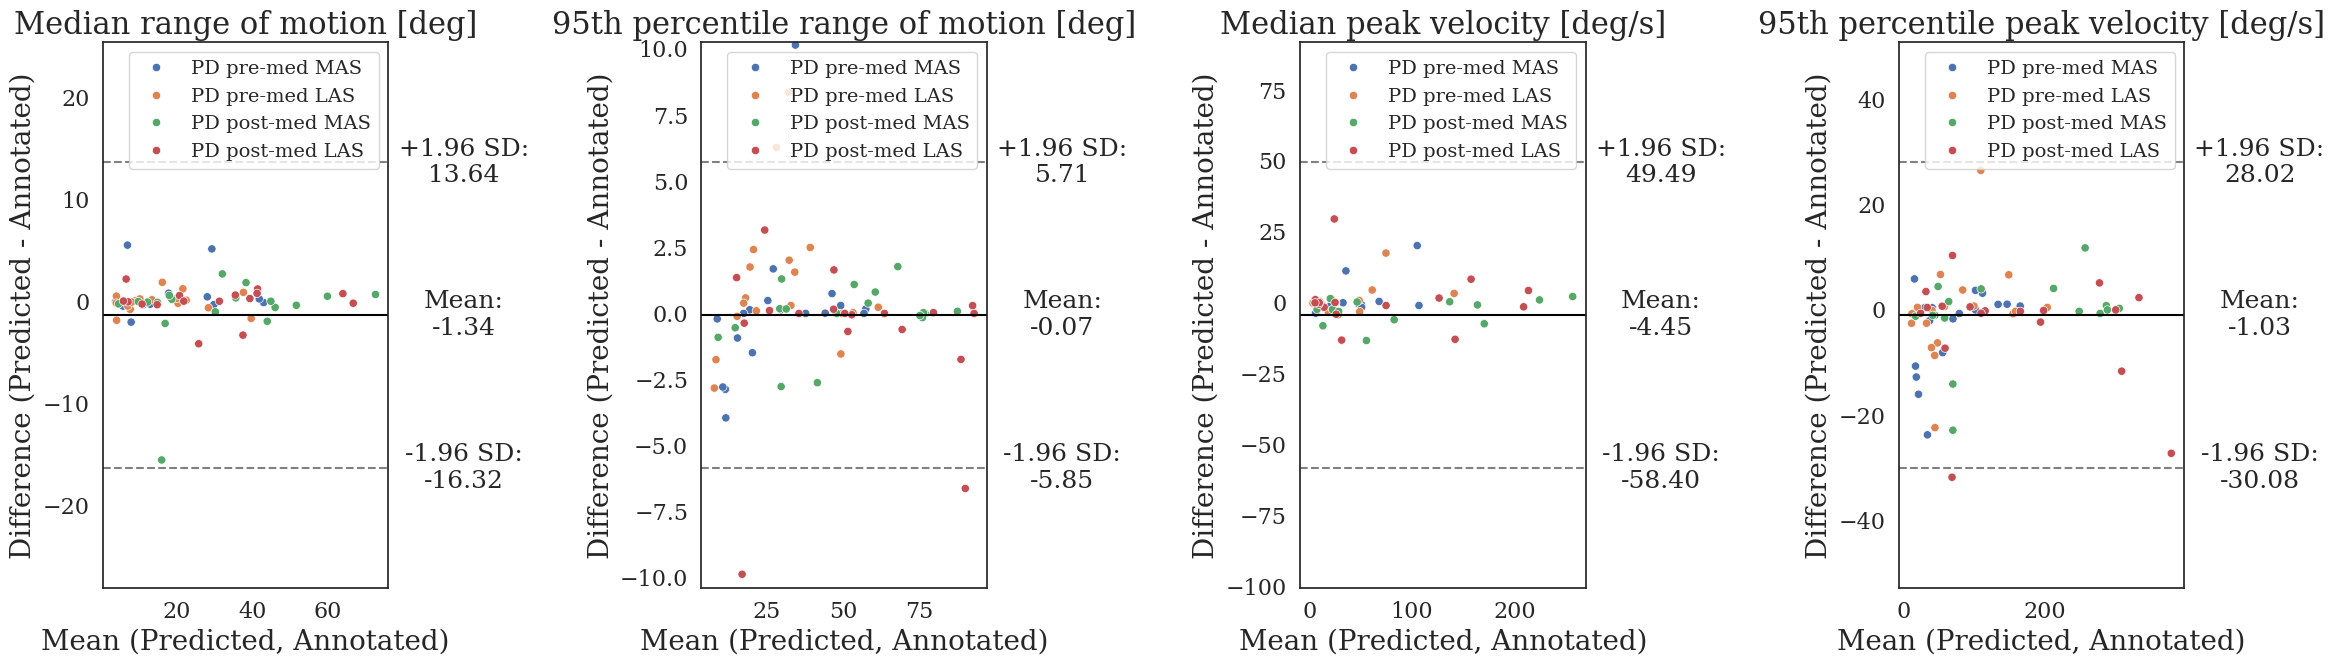

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(24,7))

for j, measure in enumerate(l_measures):
    ax[j], colors = bland_altman_plot(df_valid.loc[df_valid['dataset']=='filtered_gait'], df_valid.loc[df_valid['dataset']=='true_no_other_arm_activity'], x=measure, hue='population', axs=ax[j], legend=True, ax=ax[j])

    ax[j].legend(loc='upper right')

    ax[j].set_title(d_map_measures[measure])
    ax[j].set_xlabel('Mean (Predicted, Annotated)')
    ax[j].set_ylabel('Difference (Predicted - Annotated)')

fig.tight_layout()

plt.show()

In [15]:
measure = 'range_of_motion_median'
l_populations = ['PD pre-med MAS', 'PD pre-med LAS', 'PD post-med MAS', 'PD post-med LAS']

l_icc = []
l_pvalue = []
l_ci = []

icc_type = 'ICC1'

for population in df_valid['population'].unique():
    icc = pg.intraclass_corr(data=df_valid.loc[df_valid['population']==population], targets=ID_COLNAME, raters='dataset', ratings=measure)

    l_icc.append(icc.loc[icc['Type']==icc_type, 'ICC'].values[0])
    l_pvalue.append(icc.loc[icc['Type']==icc_type, 'pval'].values[0])
    l_ci.append(icc.loc[icc['Type']==icc_type, 'CI95%'].values[0])

pd.DataFrame([l_populations, l_icc, l_pvalue, l_ci], index=['Population', 'ICC', 'p-value', 'CI95%']).T    

,Population,ICC,p-value,CI95%
0,PD pre-med MAS,0.989582,0.0,"[0.97, 1.0]"
1,PD pre-med LAS,0.996136,0.0,"[0.99, 1.0]"
2,PD post-med MAS,0.971502,0.0,"[0.93, 0.99]"
3,PD post-med LAS,0.704729,0.000196,"[0.39, 0.87]"


#### Sensitivity of arm swing parameters

Population differences

PD pre-med vs PD post-med p-value:  0.000335693359375
PD post-med vs controls p-value:  0.31818772752936486
PD pre-med vs controls p-value:  4.017452405129734e-05


C:\Users\erik_\AppData\Local\Temp\ipykernel_12556\46195388.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['PD\npre-med', 'PD\npost-med', 'Controls'])


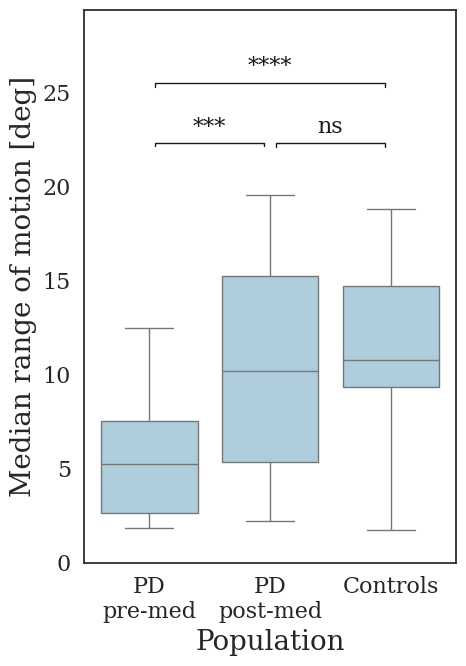

In [16]:
measure = 'range_of_motion_median'
dataset = 'filtered_gait'
sequence_duration = 'overall'

l_pd_pre_mas = [d_quant[x][dataset]['pre']['MAS']['values'][measure][sequence_duration] for x in l_valid_pd_ids]
l_pd_post_mas = [d_quant[x][dataset]['post']['MAS']['values'][measure][sequence_duration] for x in l_valid_pd_ids]
l_hc_mas = [d_quant[x][dataset]['HC']['MAS']['values'][measure][sequence_duration] for x in l_valid_hc_ids]

df_group = pd.DataFrame([l_pd_pre_mas + l_pd_post_mas + l_hc_mas], index=[measure]).T
df_group['group'] = ['PD pre-med']*len(l_pd_pre_mas) + ['PD post-med']*len(l_pd_post_mas) + ['HC']*len(l_hc_mas)

fig, ax = plt.subplots(figsize=(5,7))

sns.boxplot(x='group', y=measure, data=df_group, color=COLOR_PALETTE_FIRST_COLOR, ax=ax)

ymax = ax.get_ylim()[1]


y_min_significance = ymax * 1.05 
gap = y_min_significance * 1.05 - ymax

p_value = calculate_pvalue(l_pd_pre_mas, l_pd_post_mas, test='wilcoxon')[1]
print("PD pre-med vs PD post-med p-value: ", p_value)

plot_significance(ax=ax, x_min=0.05,
                  x_max=0.95, pvalue=p_value,
                  y_min_significance=y_min_significance, gap=gap, row=1, 
                  text_size=16) 

p_value = calculate_pvalue(l_pd_post_mas, l_hc_mas, test='ranksums')[1]
print("PD post-med vs controls p-value: ", p_value)

plot_significance(ax=ax, x_min=1.05,
                  x_max=1.95, pvalue=p_value,
                  y_min_significance=y_min_significance, gap=gap, row=1, 
                  text_size=16) 
         
p_value = calculate_pvalue(l_pd_pre_mas, l_hc_mas, test='ranksums')[1]
print("PD pre-med vs controls p-value: ", p_value)

y_min_significance = ymax * 1.2

plot_significance(ax=ax, x_min=0.05,
                  x_max=1.95, pvalue=p_value,
                  y_min_significance=y_min_significance, gap=gap, row=1, 
                  text_size=16) 

ax.set_ylim(0, 1.1*ax.get_ylim()[1])
# ax.set_xticklabels([d_pop_rename[x] for x in l_order_populations])
ax.set_xticklabels(['PD\npre-med', 'PD\npost-med', 'Controls'])

ax.set_ylabel(d_map_measures[measure])
ax.set_xlabel('Population')

fig.tight_layout()

# plt.savefig(os.path.join(path_figures, 'asq', f'{metric}_population.png'))

plt.show()

PD pre-med MAS vs PD pre-med LAS p-value:  0.48996734619140625
PD post-med MAS vs PD post-med LAS p-value:  0.25792694091796875
Controls MAS vs controls LAS p-value:  0.4274179935455322


C:\Users\erik_\AppData\Local\Temp\ipykernel_12556\4283350293.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['PD pre-med\nMAS', 'PD pre-med\nLAS', 'PD post-med\nMAS',


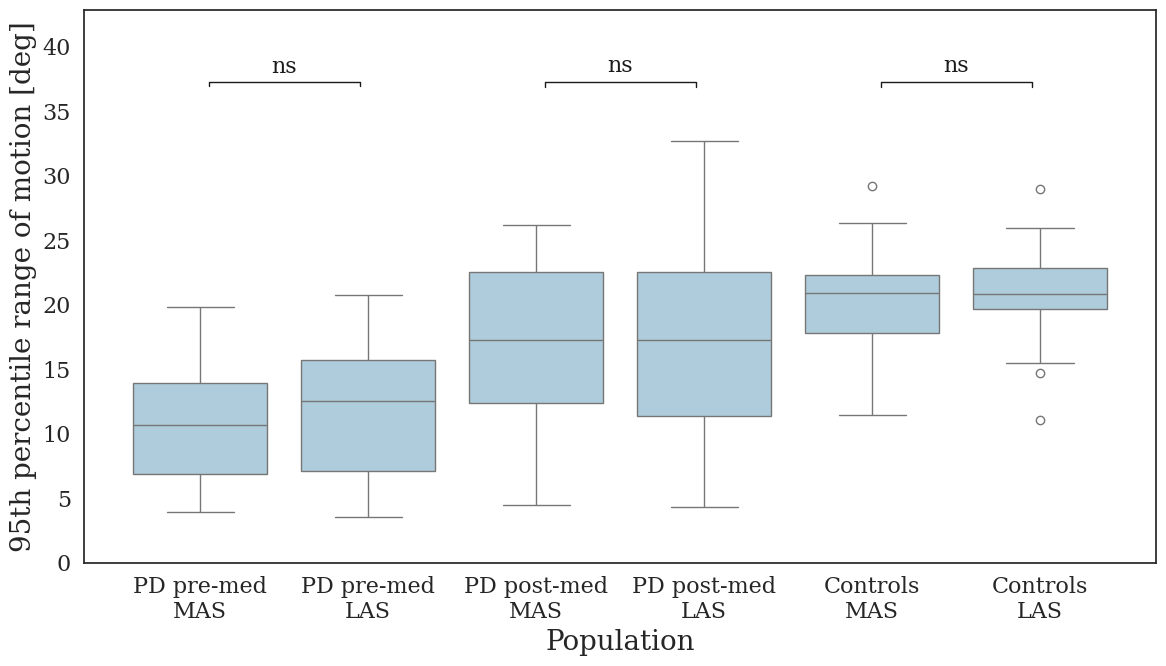

In [49]:
dataset = 'filtered_gait'
measure = 'range_of_motion_quantile_95'
sequence_duration = 'overall'

l_pd_pre_mas = [d_quant[x][dataset]['pre']['MAS']['values'][measure][sequence_duration] for x in l_valid_pd_ids]
l_pd_pre_las = [d_quant[x][dataset]['pre']['LAS']['values'][measure][sequence_duration] for x in l_valid_pd_ids]
l_pd_post_mas = [d_quant[x][dataset]['post']['MAS']['values'][measure][sequence_duration] for x in l_valid_pd_ids]
l_pd_post_las = [d_quant[x][dataset]['post']['LAS']['values'][measure][sequence_duration] for x in l_valid_pd_ids]
l_hc_mas = [d_quant[x][dataset]['HC']['MAS']['values'][measure][sequence_duration] for x in l_valid_hc_ids]
l_hc_las = [d_quant[x][dataset]['HC']['LAS']['values'][measure][sequence_duration] for x in l_valid_hc_ids]

df_group = pd.DataFrame([l_pd_pre_mas + l_pd_pre_las + l_pd_post_mas + l_pd_post_las + l_hc_mas + l_hc_las], index=[measure]).T
df_group['group'] = ['PD pre-med MAS']*len(l_pd_pre_mas) + ['PD pre-med LAS']*len(l_pd_pre_las) + ['PD post-med MAS']*len(l_pd_post_mas) + ['PD post-med LAS']*len(l_pd_post_las) + ['HC MAS']*len(l_hc_mas) + ['HC LAS']*len(l_hc_las)

fig, ax = plt.subplots(figsize=(12,7))

sns.boxplot(x='group', y=measure, data=df_group, color=COLOR_PALETTE_FIRST_COLOR, ax=ax)

ymax = ax.get_ylim()[1]

y_min_significance = ymax * 1.05
gap = y_min_significance * 1.05 - ymax

p_value = calculate_pvalue(l_pd_pre_mas, l_pd_pre_las, test='wilcoxon')[1]
print("PD pre-med MAS vs PD pre-med LAS p-value: ", p_value)

plot_significance(ax=ax, x_min=0.05,
                  x_max=0.95, pvalue=p_value,
                  y_min_significance=y_min_significance, gap=gap, row=1, 
                  text_size=16) 

p_value = calculate_pvalue(l_pd_post_mas, l_pd_post_las, test='wilcoxon')[1]
print("PD post-med MAS vs PD post-med LAS p-value: ", p_value)

plot_significance(ax=ax, x_min=2.05,
                  x_max=2.95, pvalue=p_value,
                  y_min_significance=y_min_significance, gap=gap, row=1, 
                  text_size=16) 
         
p_value = calculate_pvalue(l_hc_mas, l_hc_las, test='wilcoxon')[1]
print("Controls MAS vs controls LAS p-value: ", p_value)

plot_significance(ax=ax, x_min=4.05,
                  x_max=4.95, pvalue=p_value,
                  y_min_significance=y_min_significance, gap=gap, row=1, 
                  text_size=16) 

ax.set_ylim(0, 1.1*ax.get_ylim()[1])
# ax.set_xticklabels([d_pop_rename[x] for x in l_order_populations])
ax.set_xticklabels(['PD pre-med\nMAS', 'PD pre-med\nLAS', 'PD post-med\nMAS', 
                    'PD post-med\nLAS', 'Controls\nMAS', 'Controls\nLAS'])

# ax.set_ylabel('Peak velocity [deg/s]')
ax.set_ylabel(d_map_measures[measure])
ax.set_xlabel('Population')

fig.tight_layout()

# plt.savefig(os.path.join(path_figures, 'asq', f'{metric}_population.png'))

plt.show()

In [51]:
l_pd_pre_mas

[12.881063834037988,
 14.785409308021768,
 8.410065764842818,
 8.800936179500777,
 4.122470897739743,
 5.388816912107383,
 3.9055116476696603,
 8.416569409127082,
 11.665856255477445,
 10.689926982857619,
 4.757842198240536,
 17.761997548377686,
 16.903974318011997,
 11.043372972249518,
 4.642026354074889,
 14.087180155942026,
 8.829259794978194,
 13.742536577517317,
 19.87035076288305]

C:\Users\erik_\AppData\Local\Temp\ipykernel_12556\1783127645.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i//2,i%2].set_xticklabels(['PD\npre-med', 'PD\npost-med', 'Controls'])
C:\Users\erik_\AppData\Local\Temp\ipykernel_12556\1783127645.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i//2,i%2].set_xticklabels(['PD\npre-med', 'PD\npost-med', 'Controls'])
C:\Users\erik_\AppData\Local\Temp\ipykernel_12556\1783127645.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i//2,i%2].set_xticklabels(['PD\npre-med', 'PD\npost-med', 'Controls'])
C:\Users\erik_\AppData\Local\Temp\ipykernel_12556\1783127645.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

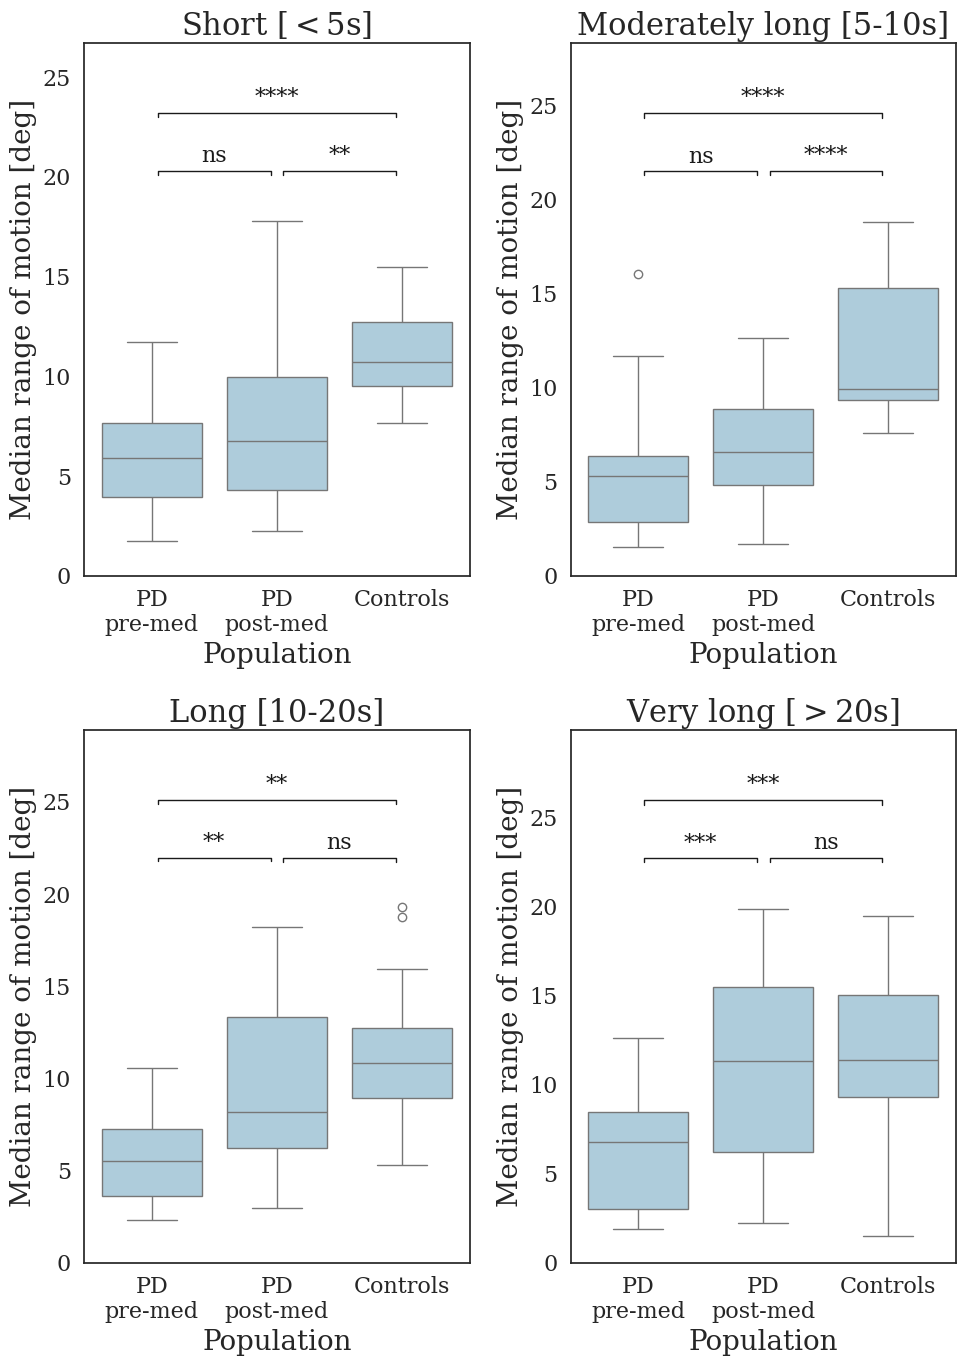

In [21]:
dataset = 'filtered_gait'
measure = 'range_of_motion_median'

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,14))

for i, sequence_duration in enumerate(D_SEQUENCE_DURATIONS.keys()):

    l_pd_ids_seq = [x for x in l_valid_pd_ids if sequence_duration in d_quant[x][dataset]['pre']['MAS']['values'][measure].keys() and sequence_duration in d_quant[x][dataset]['post']['MAS']['values'][measure].keys()]
    l_hc_ids_seq = [x for x in l_valid_hc_ids if sequence_duration in d_quant[x][dataset]['HC']['MAS']['values'][measure].keys()]

    l_pd_ids_seq_pre = [d_quant[x][dataset]['pre']['MAS']['values'][measure][sequence_duration] for x in l_pd_ids_seq]
    l_pd_ids_seq_post = [d_quant[x][dataset]['post']['MAS']['values'][measure][sequence_duration] for x in l_pd_ids_seq]
    l_hc_ids_seq = [d_quant[x][dataset]['HC']['MAS']['values'][measure][sequence_duration] for x in l_hc_ids_seq]

    df_group = pd.DataFrame([l_pd_ids_seq_pre + l_pd_ids_seq_post + l_hc_ids_seq], index=[measure]).T
    df_group['group'] = ['PD pre-med']*len(l_pd_ids_seq_pre) + ['PD post-med']*len(l_pd_ids_seq_post) + ['HC']*len(l_hc_ids_seq)

    sns.boxplot(x='group', y=measure, data=df_group, color=COLOR_PALETTE_FIRST_COLOR, ax=ax[i//2,i%2])

    ymax = ax[i//2,i%2].get_ylim()[1]

    y_min_significance = ymax * 1.05
    gap = y_min_significance * 1.05 - ymax

    p_value = calculate_pvalue(l_pd_ids_seq_pre, l_pd_ids_seq_post, test='wilcoxon')[1]

    plot_significance(ax=ax[i//2,i%2], x_min=0.05,
                    x_max=0.95, pvalue=p_value,
                    y_min_significance=y_min_significance, gap=gap, row=1, 
                    text_size=16) 
    
    p_value = calculate_pvalue(l_pd_ids_seq_post, l_hc_ids_seq, test='ranksums')[1]

    plot_significance(ax=ax[i//2,i%2], x_min=1.05,
                      x_max=1.95, pvalue=p_value,
                      y_min_significance=y_min_significance, gap=gap, row=1, 
                      text_size=16) 
    
    y_min_significance = ymax * 1.2
    
    p_value = calculate_pvalue(l_pd_ids_seq_pre, l_hc_ids_seq, test='ranksums')[1]

    plot_significance(ax=ax[i//2,i%2], x_min=0.05,
                      x_max=1.95, pvalue=p_value,
                      y_min_significance=y_min_significance, gap=gap, row=1, 
                      text_size=16) 

    ax[i//2,i%2].set_title(f"{D_SEQUENCE_DURATIONS[sequence_duration]}")
    ax[i//2,i%2].set_ylim(0, 1.1*ax[i//2,i%2].get_ylim()[1])
    # ax.set_xticklabels([d_pop_rename[x] for x in l_order_populations])
    ax[i//2,i%2].set_xticklabels(['PD\npre-med', 'PD\npost-med', 'Controls'])

    ax[i//2,i%2].set_ylabel(d_map_measures[measure])
    ax[i//2,i%2].set_xlabel('Population')

fig.tight_layout()

# plt.savefig(os.path.join(path_figures, 'asq', f'{metric}_population.png'))

plt.show()

In [26]:
filename_predictions = 'd_performance_asd.json'

with open(os.path.join(PDH_PATH_ARM_ACTIVITY_PREDICTIONS, filename_predictions), 'r') as f:
    d_performance = json.load(f)

for subject in L_PD_IDS:
    d_quant[subject]['clinical'] = d_performance[subject]['clinical']

df_filtered = df_valid.loc[df_valid['dataset']=='filtered_gait'].copy()

for subject in L_PD_IDS:
    for med_stage in ['pre', 'post']:
        for affected_side in ['MAS', 'LAS']:
            df_filtered.loc[(df_filtered[ID_COLUMN]==subject) & (df_filtered['population']==f'PD {med_stage}-med {affected_side}'), 'subscore'] = d_quant[subject]['clinical'][med_stage][affected_side]['subscore']
            df_filtered.loc[(df_filtered[ID_COLUMN]==subject) & (df_filtered['population']==f'PD {med_stage}-med {affected_side}'), 'total_score'] = d_quant[subject]['clinical'][med_stage][affected_side]['total']


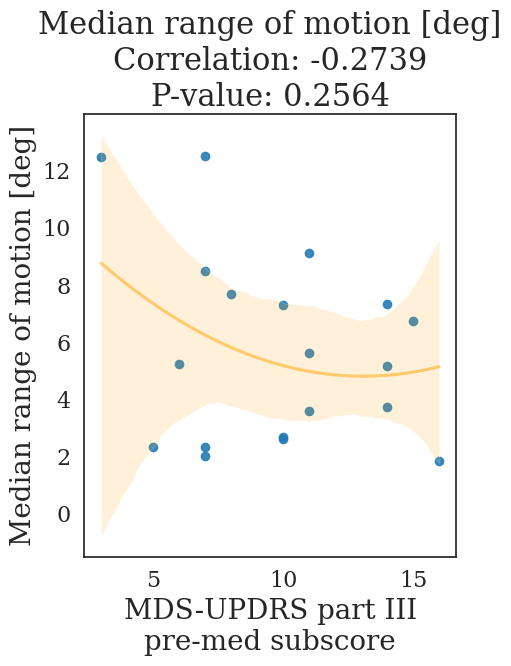

In [31]:
from scipy.stats import pearsonr, spearmanr

measure = 'range_of_motion_median'
correlation_metric = 'pearson'

df_med = df_filtered.loc[df_filtered['population']=='PD pre-med MAS']

fig, ax = plt.subplots(figsize=(5,7))

sns.scatterplot(data=df_med, x='subscore', y=measure, ax=ax, color=COLOR_PALETTE_FIRST_COLOR)
sns.regplot(x='subscore', y=measure, data=df_med, order=2,
            scatter_kws={'color': COLOR_PALETTE_SECOND_COLOR}, ci=95,
            line_kws={'color': 'orange', 'alpha': 0.5}, marker='o', label='PD patient', ax=ax)

if correlation_metric == 'pearson':
    rho = np.round(pearsonr(df_med[measure], df_med['subscore']).statistic,4)
    p_value = np.round(pearsonr(df_med[measure], df_med['subscore']).pvalue,4)
else:
    rho = np.round(spearmanr(df_med[measure], df_med['subscore']).correlation,4)
    p_value = np.round(spearmanr(df_med[measure], df_med['subscore']).pvalue,4)

ax.set_title(f"{d_map_measures[measure]}\nCorrelation: {rho}\nP-value: {p_value}")

ax.set_ylabel(d_map_measures[measure])
# ax.set_xlabel(d_clinical_rename['OFF_UPDRS_3_hypokinesia'])
ax.set_xlabel('MDS-UPDRS part III\npre-med subscore')

fig.tight_layout()

plt.show()

#### Added value of filtering gait

Sequence duration: overall
N subjects: 19/19
P-value: 0.02298736572265625


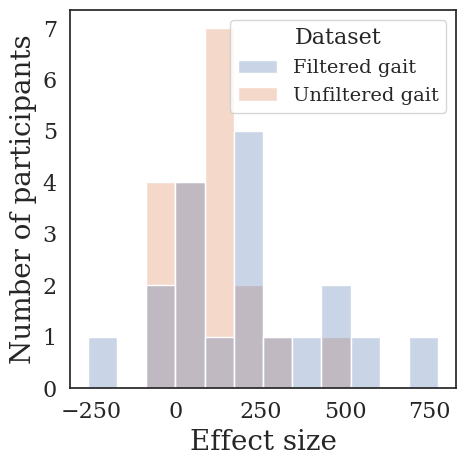

In [37]:
measure = 'median_rom'
seq_duration = 'overall'

dataset_1 = 'Predicted gait predicted NOAA'
dataset_2 = 'Predicted gait'

l_valid_ids = [x for x in l_valid_pd_ids if seq_duration in d_quant[x]['effect_size'][measure][dataset_1].keys() and seq_duration in d_quant[x]['effect_size'][measure][dataset_2].keys()] 

print(f"Sequence duration: {seq_duration}\nN subjects: {len(l_valid_ids)}/{len(l_valid_pd_ids)}")
l_vals_filtered = [(d_quant[x]['effect_size'][measure][dataset_1][seq_duration]['mu_post'] - d_quant[x]['effect_size'][measure][dataset_1][seq_duration]['mu_pre']) / d_quant[x]['effect_size'][measure][dataset_1][seq_duration]['std'] for x in l_valid_ids]
l_vals_unfiltered = [(d_quant[x]['effect_size'][measure][dataset_2][seq_duration]['mu_post'] - d_quant[x]['effect_size'][measure][dataset_2][seq_duration]['mu_pre']) / d_quant[x]['effect_size'][measure][dataset_2][seq_duration]['std'] for x in l_valid_ids]

# l_vals_filtered = [(d_quant[x]['effect_size'][measure][dataset_1]['overall']['mu_post'] - d_quant[x]['effect_size'][measure][dataset_1]['overall']['mu_pre']) / d_quant[x]['effect_size'][measure][dataset_1]['overall']['std'] for x in l_valid_pd_ids]
# l_vals_unfiltered = [(d_quant[x]['effect_size'][measure][dataset_2]['overall']['mu_post'] - d_quant[x]['effect_size'][measure][dataset_2]['overall']['mu_pre']) / d_quant[x]['effect_size'][measure][dataset_2]['overall']['std'] for x in l_valid_pd_ids]

fig, ax = plt.subplots(figsize=(5,5))

df_filtered_gait = pd.DataFrame(l_vals_filtered, columns=['effect_size'])
df_unfiltered_gait = pd.DataFrame(l_vals_unfiltered, columns=['effect_size'])

df_filtered_gait['Dataset'] = 'Filtered gait'
df_unfiltered_gait['Dataset'] = 'Unfiltered gait'

df_all = pd.concat([df_filtered_gait, df_unfiltered_gait], ignore_index=True).reset_index(drop=True)

print(f"P-value: {wilcoxon(l_vals_filtered, l_vals_unfiltered, alternative='two-sided')[1]}")

g = sns.histplot(data=df_all, x='effect_size', hue='Dataset', alpha=0.3, fill=True, bins=12, common_norm=False, legend=False)

ax.set_xlabel('Effect size')
ax.set_ylabel('Number of participants')
ax.yaxis.get_major_locator().set_params(integer=True)
ax.legend(title='Dataset', labels=['Unfiltered gait', 'Filtered gait'], reverse=True, loc='upper right')

fig.tight_layout()

plt.show()